In [1]:
from tqdm.notebook import tqdm
import pickle
from collections import defaultdict
import numpy as np
from numpy import log, log1p, exp, sqrt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

ANN_FACTOR = 52

In [2]:
# maybe need to include more than just common stocks... too little data?
with open('./data/stocks.pkl', 'rb') as f:
    stocks = pickle.load(f)

with open('./data/market.pkl', 'rb') as f:
    market = pickle.load(f)

In [3]:
# First, stocks that had not been listed for the entire two-year period were excluded due to their short history. 
# Second, stocks that were delisted within the next six-month period were also excluded.

lb = pd.to_datetime('2003-01-01') # window lower bound
two_yr = pd.DateOffset(years=2)
ub = lb + two_yr # window upper bound
six_mo = pd.DateOffset(months=6)
db = ub + six_mo # delisting bound

sp500_up_dates = market[market.sprtrn > 0].index
sp500_down_dates = market[market.sprtrn <= 0].index

# 3 types of beta, 5 quantiles => 15 time-series of annualized returns
quant_cutoffs = (0, 0.2, 0.4, 0.6, 0.8, 1)
history = defaultdict(list)
beta_hist = defaultdict(list)

while db <= stocks.date.max():
    # paper's conditions: 2 yr window size, sliding in 6 mo. increments, delisting inclusion conditions
    m1 = (stocks.date >= lb) & (stocks.date < ub) & (stocks.start < lb) & (stocks.ending >= db)
    
    m2 = (stocks.date >= ub) & (stocks.date < db)
    
    ### BETA ESTIMATION (3 TYPES) ###
    # x is design matrix of market return having shape n_obs x 2
    # y is matrix of stock returns having shape n_obs x n_stocks
    # np.linalg.inv((x.T).dot(x)).dot(x.T).dot(y) -> get \beta_1
    y_train = stocks[m1].pivot(index='date', columns='permno', values='ret').dropna(how='any', axis=1)
    y_test = stocks[m2].pivot(index='date', columns='permno', values='ret').dropna(how='any', axis=1)
    
    shared_names = list(set(y_train.columns).intersection(set(y_test.columns))) # companies must match for train and test (portfolio return)
    y_train, y_test = y_train[shared_names], y_test[shared_names]

    w1 = np.ones(y_test.shape[1]) # setting up equal weight portfolio for benchmarks
    w1 /= np.sum(w1)

    shared_dates = (y_train.index).intersection(market.index, sort=True) # dates must match for train and SP500 (regression)
    up_dates = shared_dates.intersection(sp500_up_dates, sort=True)
    down_dates = shared_dates.intersection(sp500_down_dates, sort=True)

    for dt_label, dt in zip(('all', 'up', 'down'), (shared_dates, up_dates, down_dates)):
        x_train = np.ones((len(dt), 2))
        x_train[:, 1] = market.loc[dt, 'sprtrn']
        
        # high-IQ OLS moment
        beta = np.linalg.inv((x_train.T).dot(x_train)).dot(x_train.T).dot(y_train.loc[dt, :])[1, :]
        beta_hist[f'{dt_label}_bench'].append( np.mean(beta) ) # eq-wt total portfolio beta for benchmark

        # annualized realized (future) return for eq-wt benchmark / total-market portfolio
        if dt_label == 'all':
            realized_bench = exp( log1p( y_test.dot(w1) ).mean() * ANN_FACTOR ) - 1 # (fixing paper's bias?)
            history[f'{dt_label}_bench'].append(realized_bench)

        # need to compute realized return over NEXT six mo portfolio construction via eq-wt beta-quantiles
        # annualized realized (future) return for eq-wt portfolio based on beta-quantiles
        quant_vals = np.quantile(beta, quant_cutoffs)
        for i in range(1, len(quant_vals)):
            m3 = (beta >= quant_vals[i-1])
            m3 = m3 & (beta <= quant_vals[i]) if i == len(quant_vals)-1 else m3 & (beta < quant_vals[i])
            beta_hist[f'{dt_label}_{quant_cutoffs[i]}'].append( np.mean(beta[m3]) ) # eq-wt beta-quant total portfolio beta
            name_indices = np.where(m3)[0]

            w2 = np.ones(len(name_indices)) # equal weight portfolio
            w2 /= np.sum(w2)
            realized = exp( log1p( (y_test.iloc[:, name_indices]).dot(w2) ).mean() * ANN_FACTOR ) - 1 # (fixing paper's bias?)
            history[f'{dt_label}_{quant_cutoffs[i]}'].append(realized)
    
    beta_hist['dates'].append(db)
    history['dates'].append(db)
    lb = lb + six_mo
    ub = lb + two_yr
    db = ub + six_mo

history = pd.DataFrame(history).set_index('dates')
beta_hist = pd.DataFrame(beta_hist).set_index('dates')

In [4]:
history.head(3)

,all_bench,all_0.2,all_0.4,all_0.6,all_0.8,all_1,up_0.2,up_0.4,up_0.6,up_0.8,up_1,down_0.2,down_0.4,down_0.6,down_0.8,down_1
dates,,,,,,,,,,,,,,,,
2005-07-01,0.002071,0.160362,0.049874,-0.017656,-0.028518,-0.136619,0.140282,0.036454,0.004662,-0.050579,-0.108386,0.099978,-0.014068,0.034867,-0.037939,-0.066763
2006-01-01,0.235870,0.072893,0.230379,0.204787,0.290996,0.398302,0.191680,0.119047,0.280492,0.266812,0.326121,0.106142,0.148892,0.192108,0.292010,0.466346
2006-07-01,0.020940,0.060278,0.008897,0.030131,0.021855,-0.021169,0.090498,0.023748,0.060742,-0.022969,-0.045562,0.010210,0.029903,0.002018,0.024614,0.031479


In [5]:
beta_hist.head(3)

,all_bench,all_0.2,all_0.4,all_0.6,all_0.8,all_1,up_bench,up_0.2,up_0.4,up_0.6,up_0.8,up_1,down_bench,down_0.2,down_0.4,down_0.6,down_0.8,down_1
dates,,,,,,,,,,,,,,,,,,
2005-07-01,1.176853,0.519262,0.832701,1.064451,1.351525,2.116325,1.239666,0.401284,0.818391,1.093491,1.477302,2.407864,1.071184,0.315988,0.725201,1.010338,1.310220,1.994175
2006-01-01,1.163303,0.561678,0.855344,1.071040,1.335848,1.991083,1.166972,0.349791,0.810996,1.104789,1.410489,2.157530,1.173514,0.329934,0.721158,1.091539,1.482919,2.240416
2006-07-01,1.128711,0.589402,0.859655,1.067571,1.291492,1.827312,1.136705,0.279743,0.762234,1.077076,1.380420,2.172016,1.224424,0.295608,0.750626,1.122312,1.546901,2.393082


In [6]:
beta_hist.mean(axis=0)

all_bench     1.089066
all_0.2       0.551438
all_0.4       0.851718
all_0.6       1.051767
all_0.8       1.270117
all_1         1.718531
up_bench      1.120306
up_0.2        0.390177
up_0.4        0.788204
up_0.6        1.052224
up_0.8        1.350407
up_1          2.017734
down_bench    1.069188
down_0.2      0.423506
down_0.4      0.794968
down_0.6      1.032294
down_0.8      1.284826
down_1        1.808370
dtype: float64

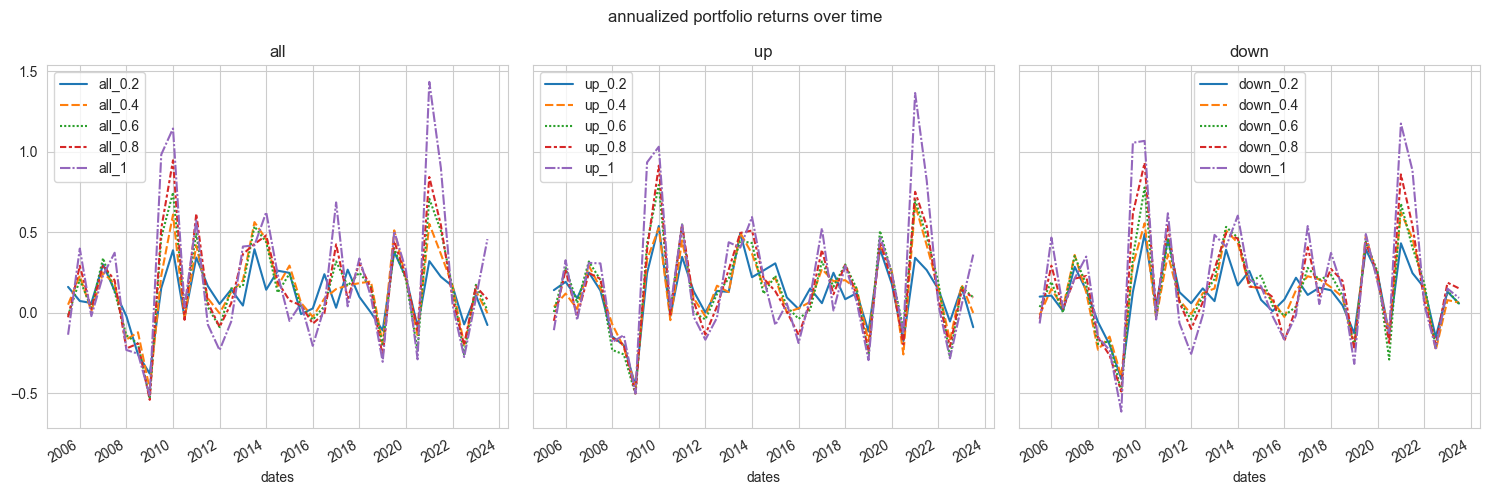

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, label in zip(axes.flatten(), ('all', 'up', 'down')):
    sns.lineplot(history[ [f'{label}_{quant}' for quant in (0.2, 0.4, 0.6, 0.8, 1)] ], ax=ax)
    ax.set_title(label)

fig.autofmt_xdate()
plt.suptitle('annualized portfolio returns over time')
plt.tight_layout(); plt.show()

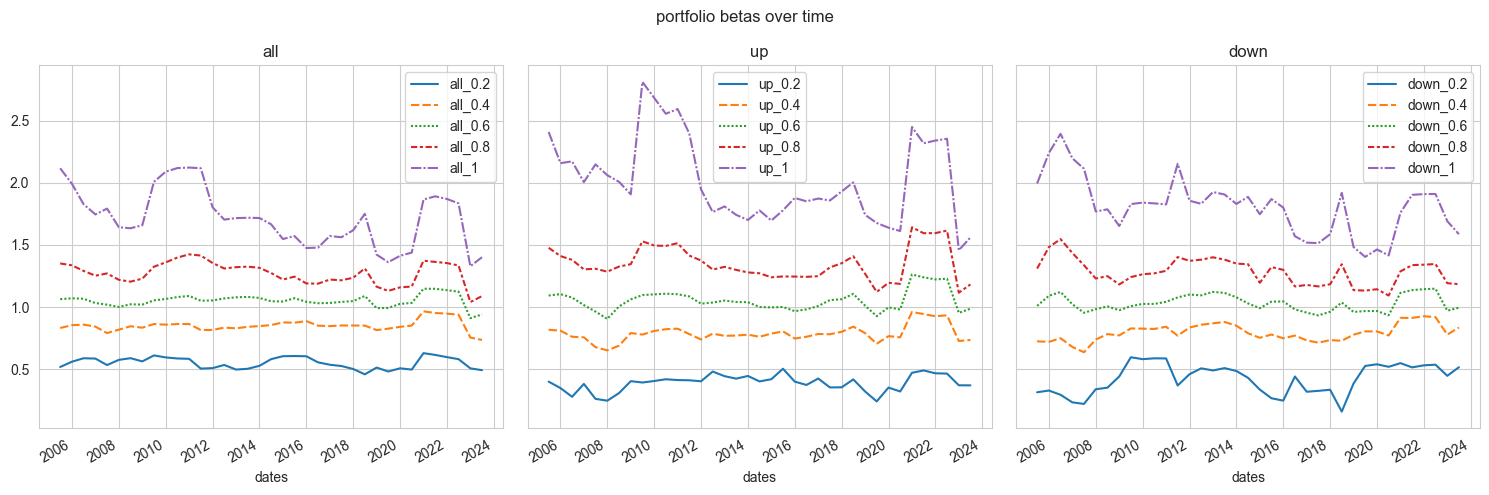

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, label in zip(axes.flatten(), ('all', 'up', 'down')):
    sns.lineplot(beta_hist[ [f'{label}_{quant}' for quant in (0.2, 0.4, 0.6, 0.8, 1)] ], ax=ax)
    ax.set_title(label)

fig.autofmt_xdate()
plt.suptitle('portfolio betas over time')
plt.tight_layout(); plt.show()

In [48]:
# ann_market = exp( log1p(market) * ANN_FACTOR ) - 1

# lb, ub = np.quantile(ann_market.ewretd, (0.15, 0.85))

# mask = (ann_market.index >= history.index.min()) & (ann_market.index <= history.index.max())
# mask = mask & (ann_market.ewretd >= lb) & (ann_market.ewretd <= ub)

# ann_market = ann_market[mask]

# fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharey=True)

# sns.lineplot(history.all_bench, ax=ax, label='equal-weight SP500 return (benchmark)')
# sns.lineplot(ann_market.ewretd, ax=ax, label='equal-weight SP500 return (non-benchmark)')

# fig.autofmt_xdate()
# plt.suptitle('annualized market portfolio returns over time')
# plt.tight_layout(); plt.show()

In [9]:
lb = pd.to_datetime('2003-01-01') # window lower bound
two_yr = pd.DateOffset(years=2)
ub = lb + two_yr # window upper bound
six_mo = pd.DateOffset(months=6)
db = ub + six_mo # delisting bound

ann_market = dict()
while ub <= market.index.max():
    m1 = (market.index >= lb) & (market.index < ub)
    ann_market[ub] = exp( log1p(market.loc[m1, 'sprtrn']).mean() * ANN_FACTOR ) - 1

    lb = lb + six_mo
    ub = lb + two_yr

ann_market = pd.DataFrame.from_dict(ann_market, orient='index')
ann_market.columns = ['sprtrn']

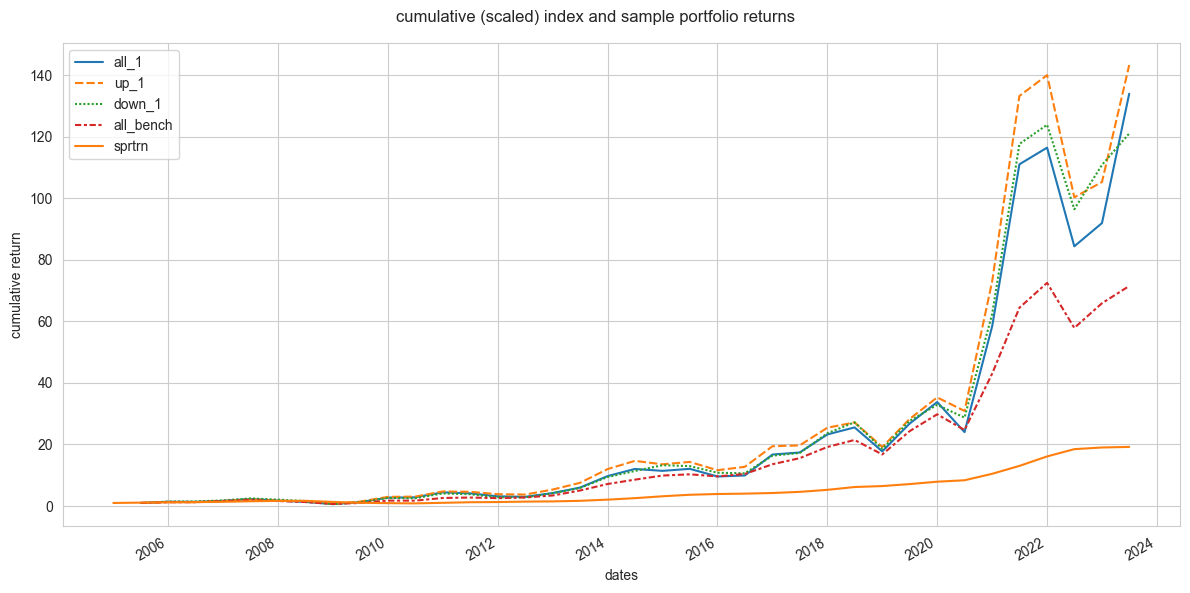

In [25]:
s1 = (history[['all_1', 'up_1', 'down_1', 'all_bench']] + 1).cumprod()
s1 /= s1.iloc[0]

s2 = (ann_market.sprtrn + 1).cumprod()
s2 /= s2.iloc[0]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(s1, ax=ax)
sns.lineplot(s2, ax=ax, label='sprtrn')
ax.set_ylabel('cumulative return')
plt.suptitle('cumulative (scaled) index and sample portfolio returns')
fig.autofmt_xdate(); plt.tight_layout(); plt.show()

In [10]:
with open('./data/history.pkl', 'wb') as f:
    pickle.dump(history, f)

with open('./data/beta_hist.pkl', 'wb') as f:
    pickle.dump(beta_hist, f)

with open('./data/ann_market.pkl', 'wb') as f:
    pickle.dump(ann_market, f)